# Functional Programming

### Helper Function

In [1]:
def pipeline(data, funcs):
    return reduce(lambda d, f: f(d), funcs, data)

## Functional Data Processing Pipeline

In [2]:
import pandas as pd
import numpy as np
from io import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce

In [3]:
load_data_from_string = lambda csv_string: pd.read_csv(StringIO(csv_string))

In [4]:
first_5_rows = lambda data: data.head()

In [5]:
def drop_columns(columns):
    return lambda data: data.drop(columns=columns)

In [6]:
data_info = lambda data: {
    'rows': data.shape[0],
    'columns': data.shape[1],
    'column_type': data.dtypes.to_dict()
}

In [7]:
get_null_value = lambda data, col: data[pd.to_numeric(data[col], errors='coerce').isna()][col].unique()

In [8]:
transform_null_value_for_col = lambda col: (
    lambda data: data.assign(**{col: pd.to_numeric(data[col], errors='coerce')})
)

In [9]:
def change_type(column, dtype='float64'):
    return lambda data: data.assign(**{column: data[column].astype(dtype)})

In [10]:
sum_null = lambda data: data.isnull().sum()

In [11]:
drop_null = lambda data: data.dropna()

In [12]:
sum_duplicates = lambda data: sum(data.duplicated())

In [13]:
remove_duplicates = lambda data: data.drop_duplicates()

In [20]:
csv_file = 'retail_sales_dataset .csv'
with open(csv_file, 'r', encoding='utf-8') as f:
    csv_text = f.read()

data = load_data_from_string(csv_text)

In [21]:
funcs = [
    drop_columns(["Transaction ID", "Customer ID"]),
    transform_null_value_for_col("Total Amount"),
    change_type("Total Amount", "float64"),
    drop_null,
    remove_duplicates
]

cleaned_data = pipeline(data, funcs)


print(f"First 5 rows after cleaning:\n{first_5_rows(cleaned_data)}\n")

print(f"Sum of missing values per column:\n{sum_null(cleaned_data)}\n")

print(f"Number of duplicated rows after cleaning: {sum_duplicates(cleaned_data)}\n")

info = data_info(cleaned_data)
print(f"Data info after cleaning:\nRows: {info['rows']}\nColumns: {info['columns']}\nColumn types: {info['column_type']}")


First 5 rows after cleaning:
         Date  Gender   Age Product Category  Quantity  Price per Unit  \
0  24/11/2023  person  34.0           Beauty       3.0            50.0   
1   27/1/2023  Female  26.0         Clothing       2.0           500.0   
2   11/2/2023    Male  50.0      Electronics       1.0            30.0   
4    5/6/2023    Male  30.0           Beauty       2.0            50.0   
5   4/25/2023  Female  45.0           Beauty       1.0            30.0   

   Total Amount  
0         150.0  
1        1000.0  
2          30.0  
4         100.0  
5          30.0  

Sum of missing values per column:
Date                0
Gender              0
Age                 0
Product Category    0
Quantity            0
Price per Unit      0
Total Amount        0
dtype: int64

Number of duplicated rows after cleaning: 0

Data info after cleaning:
Rows: 963
Columns: 7
Column types: {'Date': dtype('O'), 'Gender': dtype('O'), 'Age': dtype('float64'), 'Product Category': dtype('O'), 'Quantity

## Functional data standardize

In [22]:
def standardize_date(df, column='Date', date_format='%Y-%m-%d'):
    return df.copy().assign(**{
        column: pd.to_datetime(df[column], errors='coerce', dayfirst=True)
                     .fillna(pd.Timestamp('1900-01-01'))
                     .dt.strftime(date_format)
    })


In [23]:
def standardize_gender(df, column='Gender'):
    return df.copy().assign(**{
        column: df[column].str.title().fillna('Unknown').replace({'Person':'Unknown'})
    })

In [24]:
def standardize_product_category(df, column='Product Category'):
    return df.copy().assign(**{
        column: df[column].str.strip().str.title().fillna('Unknown')
    })

In [25]:
def standardize_numeric(df, columns=['Age','Quantity','Price per Unit','Total Amount']):
    return df.copy().assign(**{
        col: pd.to_numeric(df[col], errors='coerce') for col in columns if col in df.columns
    })

In [26]:
def recalc_total_amount(df):
    return df.copy().assign(**{
        'Total Amount': df['Quantity']*df['Price per Unit']
    }) if {'Quantity','Price per Unit'}.issubset(df.columns) else df.copy()


In [27]:
def reorder_columns(df):
    cols_order = ['Transaction ID','Date','Customer ID','Gender','Age',
                  'Product Category','Quantity','Price per Unit','Total Amount']
    return df.copy()[[c for c in cols_order if c in df.columns]]

In [28]:
standardization_funcs = [
    standardize_date,
    standardize_gender,
    standardize_product_category,
    standardize_numeric,
    recalc_total_amount,
    reorder_columns
]

final_data = pipeline(cleaned_data, standardization_funcs)
print (final_data)

           Date   Gender   Age Product Category  Quantity  Price per Unit  \
0    2023-11-24  Unknown  34.0           Beauty       3.0            50.0   
1    2023-01-27   Female  26.0         Clothing       2.0           500.0   
2    2023-02-11     Male  50.0      Electronics       1.0            30.0   
4    2023-06-05     Male  30.0           Beauty       2.0            50.0   
5    1900-01-01   Female  45.0           Beauty       1.0            30.0   
..          ...      ...   ...              ...       ...             ...   
995  1900-01-01     Male  62.0         Clothing       1.0            50.0   
996  1900-01-01     Male  52.0           Beauty       3.0            30.0   
997  1900-01-01   Female  23.0           Beauty       4.0            25.0   
998  2023-05-12   Female  36.0      Electronics       3.0            50.0   
999  2023-12-04     Male  47.0      Electronics       4.0            30.0   

     Total Amount  
0           150.0  
1          1000.0  
2            30

## Transformations

In [29]:
def Filter_by_ages(data,threshold=30):     
  return data[ data['Age'] < threshold ]

In [30]:
filtered_data=Filter_by_ages(final_data,threshold=30)

In [31]:
print(f"Filtered Data (Age < 30):")
print(f"Number of rows: {len(filtered_data)}")
print("\nFirst 5 rows:")
print(filtered_data.head())

Filtered Data (Age < 30):
Number of rows: 239

First 5 rows:
          Date  Gender   Age Product Category  Quantity  Price per Unit  \
1   2023-01-27  Female  26.0         Clothing       2.0           500.0   
10  1900-01-01    Male  23.0         Clothing       2.0            50.0   
12  2023-05-08    Male  22.0      Electronics       3.0           500.0   
16  1900-01-01  Female  27.0         Clothing       4.0            25.0   
21  1900-01-01    Male  18.0         Clothing       2.0            50.0   

    Total Amount  
1         1000.0  
10         100.0  
12        1500.0  
16         100.0  
21         100.0  


In [32]:
# Functional filter for price
filter_by_price_lambda = lambda min_price=500: lambda data: data[data['Price per Unit'] >= min_price]

# Apply the filter
filtered_data = final_data.pipe(filter_by_price_lambda(300))

print(f"Filtered Data (Price per Unit >= 300):")
print(f"Number of rows: {len(filtered_data)}")
print("\nFirst 5 rows:")
print(filtered_data.head())

Filtered Data (Price per Unit >= 300):
Number of rows: 376

First 5 rows:
          Date  Gender   Age Product Category  Quantity  Price per Unit  \
1   2023-01-27  Female  26.0         Clothing       2.0           500.0   
12  2023-05-08    Male  22.0      Electronics       3.0           500.0   
14  1900-01-01  Female  42.0      Electronics       4.0           500.0   
20  1900-01-01  Female  50.0           Beauty       1.0           500.0   
23  1900-01-01  Female  49.0         Clothing       1.0           300.0   

    Total Amount  
1         1000.0  
12        1500.0  
14        2000.0  
20         500.0  
23         300.0  


In [33]:
filtered_500 = final_data.pipe(filter_by_price_lambda(500))
print(f"High-end products (Price >= 500): {len(filtered_500)} rows")

High-end products (Price >= 500): 189 rows


In [34]:
# compose
from functools import reduce

#compose using recursion
def compose(*funcs):
    if not funcs:
        return lambda x: x  
    
    if len(funcs) == 1:
        return funcs[0]
    
    
    first, *rest = funcs
    return lambda x: first(compose(*rest)(x))



Filter_pipeline=compose(
  lambda df: Filter_by_ages(df, threshold=30),
  filter_by_price_lambda(300)
    )

In [35]:
Age_price_filter=Filter_pipeline(final_data)
print(f"Filtered Data (Price per Unit >= 300) & Filtered Data (Age < 30):")
print(f"Number of rows: {len(Age_price_filter)}")
print("\nFirst 5 rows:")
print(Age_price_filter.head())
print( Age_price_filter)

Filtered Data (Price per Unit >= 300) & Filtered Data (Age < 30):
Number of rows: 99

First 5 rows:
          Date  Gender   Age Product Category  Quantity  Price per Unit  \
1   2023-01-27  Female  26.0         Clothing       2.0           500.0   
12  2023-05-08    Male  22.0      Electronics       3.0           500.0   
25  2023-07-10  Female  28.0      Electronics       2.0           500.0   
41  1900-01-01    Male  22.0         Clothing       3.0           300.0   
55  1900-01-01  Female  26.0         Clothing       3.0           300.0   

    Total Amount  
1         1000.0  
12        1500.0  
25        1000.0  
41         900.0  
55         900.0  
           Date  Gender   Age Product Category  Quantity  Price per Unit  \
1    2023-01-27  Female  26.0         Clothing       2.0           500.0   
12   2023-05-08    Male  22.0      Electronics       3.0           500.0   
25   2023-07-10  Female  28.0      Electronics       2.0           500.0   
41   1900-01-01    Male  22.0  

In [36]:
def Compute_Age_Category (age):
  if age < 25:
    return 'Teen'
  elif age <= 35:
    return 'Young Adult'
  elif age <= 55:
    return 'Adult'
  else:
    return'Young Adult'

In [37]:
def Add_Age_Category_Column(data):
    return data.assign(Age_Category=data['Age'].apply(Compute_Age_Category))


In [38]:
data_with_new_column=(
    final_data.copy()
    .pipe(Add_Age_Category_Column)
         
)

In [39]:
print("\nFirst 20 rows as a sample:\n")
print("            === DATA WITH THE ADDED NEW AGE_CATEGORY COLUMN ===\n")
print(data_with_new_column.head(20))



First 20 rows as a sample:

            === DATA WITH THE ADDED NEW AGE_CATEGORY COLUMN ===

          Date   Gender   Age Product Category  Quantity  Price per Unit  \
0   2023-11-24  Unknown  34.0           Beauty       3.0            50.0   
1   2023-01-27   Female  26.0         Clothing       2.0           500.0   
2   2023-02-11     Male  50.0      Electronics       1.0            30.0   
4   2023-06-05     Male  30.0           Beauty       2.0            50.0   
5   1900-01-01   Female  45.0           Beauty       1.0            30.0   
6   1900-01-01     Male  46.0         Clothing       2.0            25.0   
7   1900-01-01     Male  30.0      Electronics       4.0            25.0   
9   2023-07-10   Female  52.0         Clothing       4.0            50.0   
10  1900-01-01     Male  23.0         Clothing       2.0            50.0   
11  1900-01-01     Male  35.0           Beauty       3.0            25.0   
12  2023-05-08     Male  22.0      Electronics       3.0           500

In [40]:
functional_describe = lambda data: data[['Age', 'Quantity', 'Price per Unit', 'Total Amount']].describe()

In [41]:
describe_pipeline = lambda: lambda data: data[['Age', 'Quantity', 'Price per Unit', 'Total Amount']].describe()
stats_functional = final_data.pipe(describe_pipeline())

In [42]:
print("=== FUNCTIONAL ===")
print(functional_describe(final_data))

=== FUNCTIONAL ===
              Age    Quantity  Price per Unit  Total Amount
count  963.000000  963.000000      963.000000    963.000000
mean    41.372793    2.523364      177.762201    453.307373
std     13.641808    1.131768      189.214655    560.404323
min     18.000000    1.000000       25.000000     25.000000
25%     30.000000    2.000000       30.000000     60.000000
50%     42.000000    3.000000       50.000000    120.000000
75%     53.000000    4.000000      300.000000    900.000000
max     64.000000    4.000000      500.000000   2000.000000


In [43]:
task3_pipeline = compose(
    lambda df: Filter_by_ages(df, threshold=30),
    filter_by_price_lambda(300),
    Add_Age_Category_Column
)

task3_data = task3_pipeline(final_data)  

print(f"Filtered & Transformed Data (Age < 30 & Price >= 300 with Age_Category):")
print(f"Number of rows: {len(task3_data)}\n")
print("First 5 rows:")
print(task3_data.head(), "\n")

print("Descriptive statistics for numeric columns:")
print(functional_describe(task3_data))

Filtered & Transformed Data (Age < 30 & Price >= 300 with Age_Category):
Number of rows: 99

First 5 rows:
          Date  Gender   Age Product Category  Quantity  Price per Unit  \
1   2023-01-27  Female  26.0         Clothing       2.0           500.0   
12  2023-05-08    Male  22.0      Electronics       3.0           500.0   
25  2023-07-10  Female  28.0      Electronics       2.0           500.0   
41  1900-01-01    Male  22.0         Clothing       3.0           300.0   
55  1900-01-01  Female  26.0         Clothing       3.0           300.0   

    Total Amount Age_Category  
1         1000.0  Young Adult  
12        1500.0         Teen  
25        1000.0  Young Adult  
41         900.0         Teen  
55         900.0  Young Adult   

Descriptive statistics for numeric columns:
             Age   Quantity  Price per Unit  Total Amount
count  99.000000  99.000000       99.000000     99.000000
mean   23.373737   2.666667      403.030303   1058.585859
std     3.409428   1.142857   

## Data Analysis

In [44]:
# Functional helpers
pipe = lambda Data, func: func(Data)

get_summary = lambda d: d.describe()
get_correlation = lambda d: (
    d.assign(**{"Total Amount": pd.to_numeric(d["Total Amount"], errors="coerce")})
     .drop(columns=["Transaction ID"], errors='ignore')
     .corr(numeric_only=True)
)

In [45]:
get_age_trend = lambda d: (
    d.assign(
        Age=pd.to_numeric(d["Age"], errors="coerce"),
        Total_Amount=pd.to_numeric(d["Total Amount"], errors="coerce")
    )
    .groupby("Age", as_index=False)
    .agg(total_amount=("Total_Amount", "sum"))
)


In [46]:
get_monthly_trend = lambda d: (
    d.assign(
        Date=pd.to_datetime(d["Date"], errors='coerce', dayfirst=True),
        Total_Amount=pd.to_numeric(d["Total Amount"], errors="coerce")
    )
    .assign(Month=lambda x: x["Date"].dt.to_period("M"))
    .groupby("Month", as_index=False)
    .agg(monthly_revenue=("Total_Amount", "mean"))
)


In [47]:
# Apply functional pipeline
functional_summary = pipe(task3_data, get_summary)
functional_correlation = pipe(task3_data, get_correlation)
functional_age_trend = pipe(task3_data, get_age_trend)
functional_monthly_trend = pipe(task3_data, get_monthly_trend)

C:\Users\HP\AppData\Local\Temp\ipykernel_3056\4028579145.py:3: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  Date=pd.to_datetime(d["Date"], errors='coerce', dayfirst=True),


In [48]:
results = {
    "summary": functional_summary,
    "correlation": functional_correlation,
    "age_trend": functional_age_trend,
    "monthly_trend": functional_monthly_trend
}

In [49]:
results["summary"]

,Age,Quantity,Price per Unit,Total Amount
count,99.000000,99.000000,99.000000,99.000000
mean,23.373737,2.666667,403.030303,1058.585859
std,3.409428,1.142857,100.462751,508.902401
min,18.000000,1.000000,300.000000,300.000000
25%,21.000000,2.000000,300.000000,600.000000
50%,23.000000,3.000000,500.000000,1000.000000
75%,26.000000,4.000000,500.000000,1350.000000
max,29.000000,4.000000,500.000000,2000.000000


In [50]:
results["age_trend"]

,Age,total_amount
0,18.0,10200.0
1,19.0,11000.0
2,20.0,6500.0
3,21.0,11300.0
4,22.0,11600.0
5,23.0,6600.0
6,24.0,4800.0
7,25.0,8600.0
8,26.0,13300.0
9,27.0,8100.0


In [51]:
results["monthly_trend"]

,Month,monthly_revenue
0,1900-01,1201.724138
1,2023-01,744.444444
2,2023-03,733.333333
3,2023-04,750.000000
4,2023-05,1000.000000
5,2023-06,916.666667
6,2023-07,1250.000000
7,2023-08,760.000000
8,2023-09,1200.000000
9,2023-10,300.000000


In [52]:
results["correlation"]

,Age,Quantity,Price per Unit,Total Amount
Age,1.000000,-0.082928,-0.107609,-0.141544
Quantity,-0.082928,1.000000,-0.142199,0.823434
Price per Unit,-0.107609,-0.142199,1.000000,0.399660
Total Amount,-0.141544,0.823434,0.399660,1.000000


In [53]:
cleaned_data = pipeline(data.copy(), funcs)
analysis_data = pipeline(cleaned_data, standardization_funcs)

print(analysis_data)

           Date   Gender   Age Product Category  Quantity  Price per Unit  \
0    2023-11-24  Unknown  34.0           Beauty       3.0            50.0   
1    2023-01-27   Female  26.0         Clothing       2.0           500.0   
2    2023-02-11     Male  50.0      Electronics       1.0            30.0   
4    2023-06-05     Male  30.0           Beauty       2.0            50.0   
5    1900-01-01   Female  45.0           Beauty       1.0            30.0   
..          ...      ...   ...              ...       ...             ...   
995  1900-01-01     Male  62.0         Clothing       1.0            50.0   
996  1900-01-01     Male  52.0           Beauty       3.0            30.0   
997  1900-01-01   Female  23.0           Beauty       4.0            25.0   
998  2023-05-12   Female  36.0      Electronics       3.0            50.0   
999  2023-12-04     Male  47.0      Electronics       4.0            30.0   

     Total Amount  
0           150.0  
1          1000.0  
2            30

Analysis and visualization for the whole dataset

In [61]:
def plot_corr():
    def inner(df):
        corr = df.select_dtypes(include="number").corr()
        print("\n=== Correlation Matrix ===")
        print(corr)
        plt.figure(figsize=(15,10))
        sns.heatmap(corr, annot=True, cmap="coolwarm")
        plt.show()
        return df
    return inner


C:\Users\HP\AppData\Local\Temp\ipykernel_3056\4028579145.py:3: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  Date=pd.to_datetime(d["Date"], errors='coerce', dayfirst=True),


=== Summary ===
              Age    Quantity  Price per Unit  Total Amount
count  963.000000  963.000000      963.000000    963.000000
mean    41.372793    2.523364      177.762201    453.307373
std     13.641808    1.131768      189.214655    560.404323
min     18.000000    1.000000       25.000000     25.000000
25%     30.000000    2.000000       30.000000     60.000000
50%     42.000000    3.000000       50.000000    120.000000
75%     53.000000    4.000000      300.000000    900.000000
max     64.000000    4.000000      500.000000   2000.000000

=== Correlation ===
                     Age  Quantity  Price per Unit  Total Amount
Age             1.000000 -0.023019       -0.036084     -0.058640
Quantity       -0.023019  1.000000        0.022197      0.372399
Price per Unit -0.036084  0.022197        1.000000      0.854782
Total Amount   -0.058640  0.372399        0.854782      1.000000

=== Age Trend (first 5 rows) ===
    Age  total_amount
0  18.0       11215.0
1  19.0       11870.

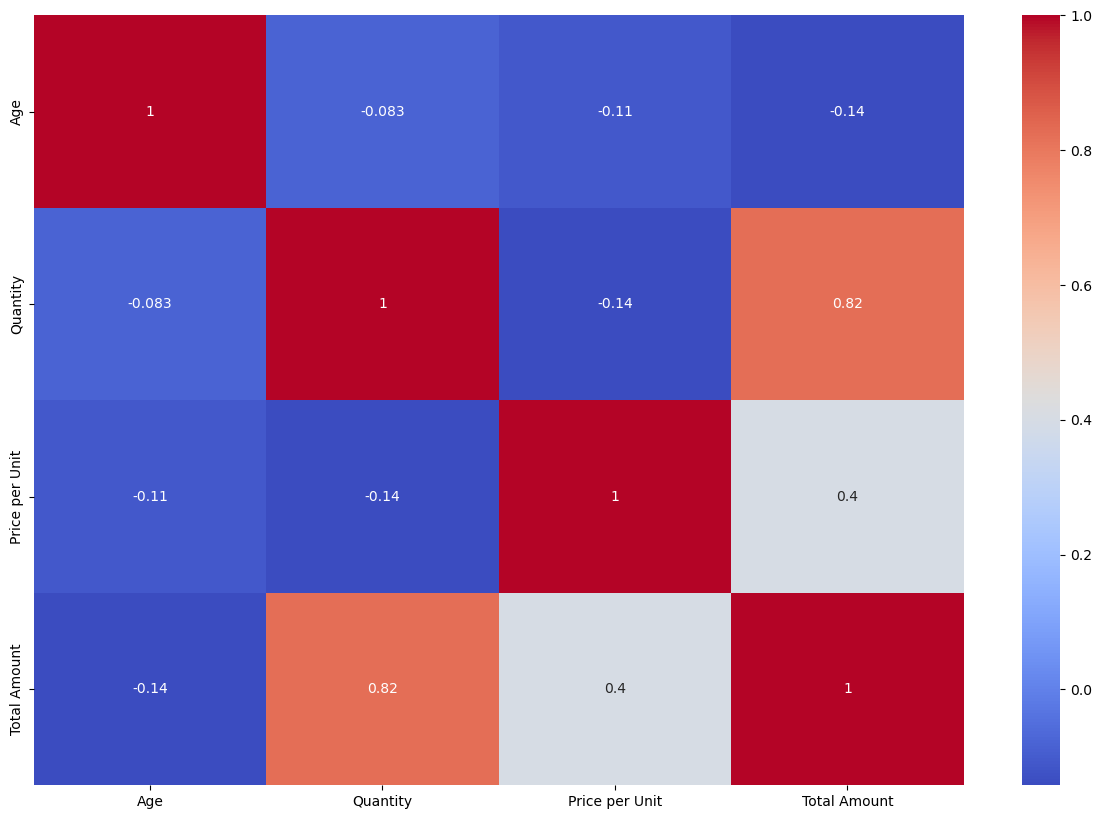

,Date,Gender,Age,Product Category,Quantity,Price per Unit,Total Amount,Age_Category
1,2023-01-27,Female,26.0,Clothing,2.0,500.0,1000.0,Young Adult
12,2023-05-08,Male,22.0,Electronics,3.0,500.0,1500.0,Teen
25,2023-07-10,Female,28.0,Electronics,2.0,500.0,1000.0,Young Adult
41,1900-01-01,Male,22.0,Clothing,3.0,300.0,900.0,Teen
55,1900-01-01,Female,26.0,Clothing,3.0,300.0,900.0,Young Adult
...,...,...,...,...,...,...,...,...
903,2023-04-07,Male,28.0,Clothing,1.0,500.0,500.0,Young Adult
908,2023-01-10,Male,26.0,Electronics,1.0,300.0,300.0,Young Adult
924,2023-03-09,Male,25.0,Electronics,1.0,300.0,300.0,Young Adult
963,1900-01-01,Male,24.0,Clothing,3.0,300.0,900.0,Teen


In [63]:
# analysis for the whole dataset
summary_results = get_summary(analysis_data)
correlation_results = get_correlation(analysis_data)
age_trend_results = get_age_trend(analysis_data)
monthly_trend_results = get_monthly_trend(analysis_data)

# =========================
# --- Display Results ---
# =========================
print(f"=== Summary ===\n{summary_results}\n")
print(f"=== Correlation ===\n{correlation_results}\n")
print(f"=== Age Trend (first 5 rows) ===\n{age_trend_results.head()}\n")
print(f"=== Monthly Trend (first 5 rows) ===\n{monthly_trend_results.head()}\n")
(
    task3_data.copy()
    .pipe(plot_corr())
)


## Data Visualization


=== Category Breakdown (Functional) ===
  Product Category  total_revenue
1         Clothing       148155.0
2      Electronics       147455.0
0           Beauty       140925.0


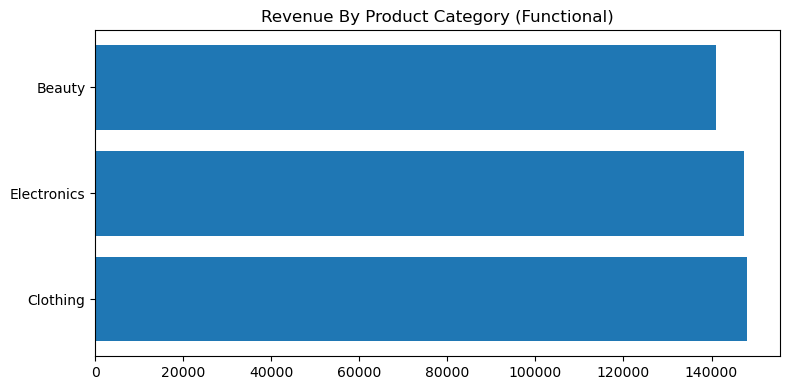

In [60]:
clean_amount = lambda d: (
    d.assign(Total_Amount=pd.to_numeric(d["Total Amount"], errors="coerce"))
)

get_category_revenue = lambda d: (
    d.groupby("Product Category", as_index=False)
     .agg(total_revenue=("Total_Amount", "sum"))
     .sort_values("total_revenue", ascending=False)
)

df_clean2 = clean_amount(cleaned_data.copy())
category_f = get_category_revenue(df_clean2)

print("\n=== Category Breakdown (Functional) ===")
print(category_f)

plt.figure(figsize=(8,4))
plt.barh(category_f["Product Category"], category_f["total_revenue"])
plt.title("Revenue By Product Category (Functional)")
plt.tight_layout()
plt.show()


## Output

In [910]:
# Results of applying all the processing functions


aggregated = (
     data.copy()
    .pipe(drop_columns(["Transaction ID", "Customer ID"])) 
    .pipe(drop_null)
    .pipe(remove_duplicates)
    .pipe(standardize_date)
    .pipe(standardize_gender)
    .pipe(standardize_product_category)
    .pipe(standardize_numeric)
    .pipe(recalc_total_amount)
    .pipe(reorder_columns)
    .pipe(Add_Age_Category_Column)
    .pipe(Filter_by_ages, threshold=30)
    .pipe(filter_by_price_lambda(min_price=300))
)


# Export to our file
output_path = "functional_processed_data.csv"
aggregated.to_csv(output_path, index=False)
# print to the console
print("\n=== FILE CONTENT ===\n")
print (aggregated)
print(f"Data exported successfully → {output_path}")



=== FILE CONTENT ===

           Date  Gender   Age Product Category  Quantity  Price per Unit  \
1    2023-02-27  Female  26.0         Clothing       2.0           500.0   
12   2023-08-05    Male  22.0      Electronics       3.0           500.0   
25   2023-10-07  Female  28.0      Electronics       2.0           500.0   
41   2023-02-17    Male  22.0         Clothing       3.0           300.0   
55   2023-05-31  Female  26.0         Clothing       3.0           300.0   
..          ...     ...   ...              ...       ...             ...   
903  2023-07-04    Male  28.0         Clothing       1.0           500.0   
908  2023-10-01    Male  26.0      Electronics       1.0           300.0   
924  2023-09-03    Male  25.0      Electronics       1.0           300.0   
963  2023-01-31    Male  24.0         Clothing       3.0           300.0   
982  2023-11-01  Female  29.0         Clothing       1.0           300.0   

     Total Amount Age_Category  
1          1000.0  Young Adult 

C:\Users\hp\AppData\Local\Temp\ipykernel_4508\1396781236.py:3: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  column: pd.to_datetime(df[column], errors='coerce', dayfirst=True)


In [911]:
import os
os.getcwd()


'C:\\Users\\hp\\concept project'